## High level approach
1. Train on Peace Arch southbound data that does not consider year (yearly trends for north vs south data is not similar
2. Impute for Peace Arch northbound
3. Evalute

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from BorderModel import BorderImpute
from BorderQuery import select_mungedata_simple
from sklearn.ensemble import ExtraTreesRegressor
from dbhelper import pd_query
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

def run_imputer(model, source_df, target_df, threshold, window):
    imputer = BorderImpute(window=window, threshold=threshold, progressbar=False)
    dfsource = imputer.prepare_source(source_df)
    imputer.build_model(model)
    imputer.prepare_target(target_df).head()
    imputer.predict()
    return imputer

In [5]:
def plot_line(target, series, start, end):
    plt.figure(figsize=(16,5))
    plt.subplot(211)
    plt.plot(target[(target.index >= start) & (target.index < end)].waittime)
    plt.subplot(212)
    plt.plot(series[(series.index >= start) & (series.index < end)]);

In [6]:
def plot_hist(series):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.xlim([0,50])
    plt.hist(series, bins=100)
    plt.subplot(122)
    plt.hist(series, bins=50);

In [7]:
source_query = '''
               select 
                   c.date,
                   month,
                   week,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 3
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=1
                   and valid = 1
                   and waittime is not null
                   and c.date > '{0}'
                order by c.date;
               '''

In [14]:
target_query = '''
               select 
                   c.date,
                   month,
                   week,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = {0}
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id={1}
                   and valid = 1
                   and waittime is not null
                   and c.date > '{2}'
                order by c.date;
                '''

## Start with creating smoothed volume data for munger_id = 3 

In [ ]:
import os
from ipyparallel import Client
rc = Client()
dview = rc[:]

# set proper working directory on all clients
cwd = os.getcwd()
dview.map(os.chdir, [cwd] * 32)
# print(dview.apply_sync(os.getcwd))

with dview.sync_imports():
    from BorderModel import smooth

In [ ]:
pr2 = rc[0].apply_async(smooth, 3, 2, 'volume', path='/home/ubuntu/BorderCrossing/data')
pr6 = rc[1].apply_async(smooth, 3, 6, 'volume', path='/home/ubuntu/BorderCrossing/data')
pr1 = rc[2].apply_async(smooth, 3, 1, 'volume', path='/home/ubuntu/BorderCrossing/data')
pr5 = rc[3].apply_async(smooth, 3, 5, 'volume', path='/home/ubuntu/BorderCrossing/data')

## Train BorderImpute with Peace Arch southbound
* Volume is smoothed, waittime is not
* Threshold is 10 mins by default

In [3]:
imputer = BorderImpute(window=24, threshold=11)

# Get source data with neighbor features
source_query = '''
               select 
                   c.date,
                   month,
                   week,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 3
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=1
                   and valid = 1
                   and waittime is not null
                order by c.date;
               '''

dfsource0 = pd_query(source_query).set_index('date')

In [11]:
dfsource = imputer.prepare_source(dfsource0)
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)

In [12]:
from BorderModel import BorderImpute
imputer.build_model(model)

In [13]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sorted(zip(imputer.columns_ll, imputer.model_ll.feature_importances_), key=lambda x: x[1])[::-1])
pp.pprint(sorted(zip(imputer.columns_lead, imputer.model_lead.feature_importances_), key=lambda x: x[1])[::-1])
pp.pprint(sorted(zip(imputer.columns_lag, imputer.model_lag.feature_importances_), key=lambda x: x[1])[::-1])

[   ('lag', 0.22890124971937909),
    ('lead', 0.22855604146940309),
    ('minofday', 0.20631346430781683),
    ('volume', 0.14923602523481055),
    ('week', 0.074057142558422509),
    ('dayofweek', 0.058755861428114779),
    ('month', 0.054180215282053211)]
[   ('lead', 0.28844409400861543),
    ('minofday', 0.25818915022909111),
    ('volume', 0.21572682088562337),
    ('week', 0.10841274236756569),
    ('dayofweek', 0.067969971692208836),
    ('month', 0.061257220816895684)]
[   ('lag', 0.29096868979888191),
    ('minofday', 0.25840916950399812),
    ('volume', 0.21552193902222314),
    ('week', 0.11036066182086816),
    ('dayofweek', 0.065218813845303716),
    ('month', 0.059520726008724982)]


## Predict Northbound Peace Arch

In [59]:
target_query = '''
               select 
                   c.date,
                   month,
                   week,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 3
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=2
                   and valid = 1
                   and waittime is not null
                order by c.date;
               '''

target_df = pd_query(target_query)
target_df = target_df.set_index('date')

In [15]:
imputer.prepare_target(target_df).head(20)

,month,week,dayofweek,minofday,volume,waittime,lead,lag
date,,,,,,,,
2007-01-02 10:00:00,1,1,1,600,8.40680,NaN,6.120000,NaN
2007-01-02 10:05:00,1,1,1,605,8.71902,NaN,6.071429,NaN
2007-01-02 10:10:00,1,1,1,610,9.03397,NaN,5.888889,NaN
2007-01-02 10:15:00,1,1,1,615,9.35477,NaN,5.629630,NaN
2007-01-02 10:20:00,1,1,1,620,9.72995,5,5.857143,NaN
2007-01-02 10:25:00,1,1,1,625,10.18920,5,7.000000,5
2007-01-02 10:30:00,1,1,1,630,10.63440,NaN,7.000000,5
2007-01-02 10:35:00,1,1,1,635,10.99910,NaN,7.000000,5
2007-01-02 10:40:00,1,1,1,640,11.20190,NaN,8.600000,5


In [16]:
imputer.predict()

221218
105082
59364
40294
31507
27654
25216
23259
21409
19717
18233
16831
15572
14453
13459
12600
11920
11344
10768
10192
9631
9103
8620
8219
7918
7630
7342
7054
6766
6487
6281
6137
6039
5943
5847
5751
5655
5559
5463
5400
5352
5304
5256
5208
5160
5112
5064
5016
4968
4920
4872
4824
4776
4728
4680
4632
4584
4536
4488
4440
4392
4344
4296
4248
4200
4152
4104
4056
4008
3960
3912
3864
3816
3768
3720
3672
3624
3576
3528
3480
3432
3384
3336
3288
3240
3192
3144
3096
3048
3000
2952
2904
2856
2808
2760
2712
2664
2616
2568
2520
2472
2424
2376
2328
2280
2232
2184
2136
2088
2040
1992
1944
1896
1848
1800
1752
1704
1656
1608
1560
1512
1464
1416
1368
1320
1272
1224
1176
1128
1080
1032
984
936
888
840
792
744
696
648
600
552
504
456
408
360
312
264
216
168
120
72
24
0


## Verify that histogram is sensible

### Northbound waittime histogram

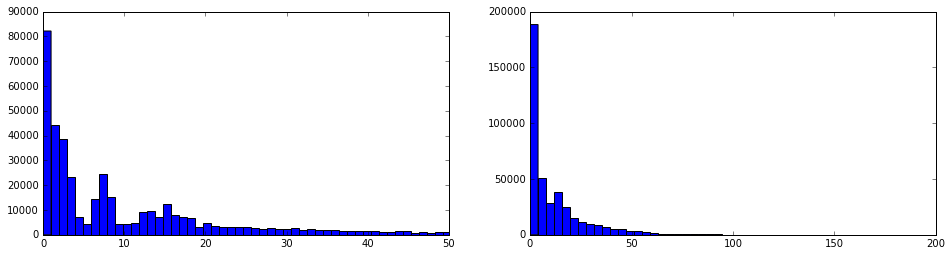

In [42]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.xlim([0,50])
plt.hist(imputer.predictdf.waittime, bins=200)
plt.subplot(122)
plt.hist(imputer.predictdf.waittime, bins=50);

### Compare to southbound

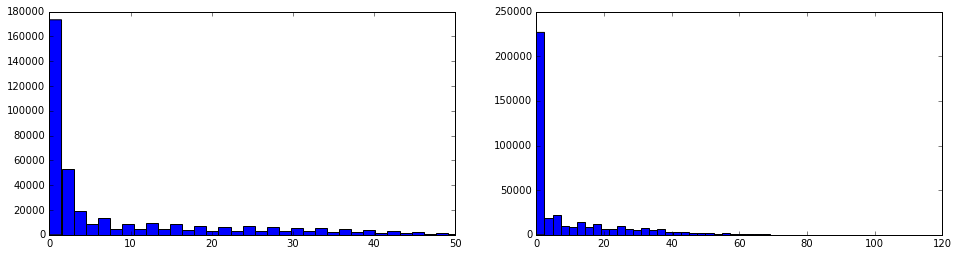

In [41]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.hist(dfsource0.waittime, bins=80)
plt.xlim([0,50])
plt.subplot(122)
plt.hist(dfsource0.waittime, bins=50);

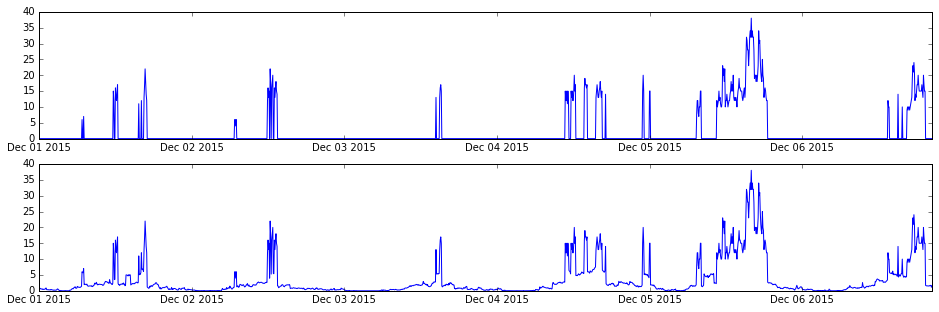

In [22]:
start = '2015-12-1'
end = '2015-12-7'
plt.figure(figsize=(16,5))
plt.subplot(211)
plt.plot(target_df[(target_df.index >= start) & (target_df.index < end)].waittime)
plt.subplot(212)
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime);

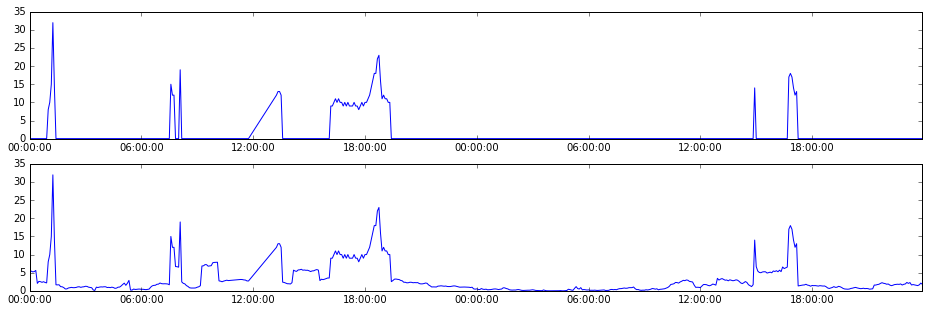

In [23]:
start = '2015-1-4'
end = '2015-1-6'
plt.figure(figsize=(16,5))
plt.subplot(211)
plt.plot(target_df[(target_df.index >= start) & (target_df.index < end)].waittime)
plt.subplot(212)
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime);

## There are large gaps in data before 2012 calling data quality in question.  Try same approach with data starting from 2012.

In [64]:
imputer = BorderImpute(window=24, threshold=13)

# Get source data with neighbor features
source_query = '''
               select 
                   c.date,
                   month,
                   week,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 3
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=1
                   and valid = 1
                   and waittime is not null
                   and c.date > '2012-1-1'
                order by c.date;
               '''

In [35]:
dfsource0 = pd_query(source_query).set_index('date')
dfsource = imputer.prepare_source(dfsource0)
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)

In [36]:
imputer.build_model(model)

In [65]:
target_query = '''
               select 
                   c.date,
                   month,
                   week,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 3
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=2
                   and valid = 1
                   and waittime is not null
                   and c.date > '2012-1-1'
                order by c.date;
               '''

target_df = pd_query(target_query)
target_df = target_df.set_index('date')

In [38]:
imputer.prepare_target(target_df).head()

,month,week,dayofweek,minofday,volume,waittime,lead,lag
date,,,,,,,,
2012-01-02 21:00:00,1,1,0,1260,23.4133,11,10.436364,NaN
2012-01-02 21:05:00,1,1,0,1265,28.5100,12,9.260000,11.000000
2012-01-02 21:10:00,1,1,0,1270,35.1091,9,9.545455,11.648649
2012-01-02 21:15:00,1,1,0,1275,38.8908,10,9.000000,10.204545
2012-01-02 21:20:00,1,1,0,1280,40.2554,9,9.000000,10.140000


In [39]:
imputer.predict()

92794
34378
12779
5160
2349
1367
930
588
284
112
35
0


### Much faster to converge indicating much fewer large gaps

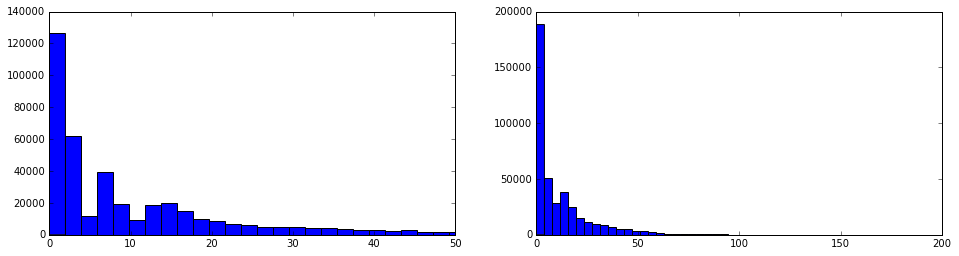

In [40]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.xlim([0,50])
plt.hist(imputer.predictdf.waittime, bins=100)
plt.subplot(122)
plt.hist(imputer.predictdf.waittime, bins=50);

### The histogram should be smoother.  See Peace Arch as example.
## Try different values for threshold and window

In [75]:
import os
from BorderModel import BorderImpute
from ipyparallel import Client
rc = Client()
dview = rc[:]

# set proper working directory on all clients
cwd = os.getcwd()
dview.map(os.chdir, [cwd] * 32)
# print(dview.apply_sync(os.getcwd))

with dview.sync_imports():
    from BorderModel import BorderImpute
    from sklearn.ensemble import ExtraTreesRegressor

importing BorderImpute from BorderModel on engine(s)
importing ExtraTreesRegressor from sklearn.ensemble on engine(s)


In [79]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
pr = {}
imp = {}
cpu = 0 
for thresh in [14, 15, 16, 17]:
#     pr[thresh] = rc[cpu].apply_async(run_imputer, model, dfsource0, target_df, thresh, 48)
    imp[thresh] = run_imputer(model, dfsource0, target_df, thresh, 48)
    cpu += 1

34378
5160
1367
588
112
0
34378
5160
1367
588
112
0
34378
5160
1367
588
112
0
34378
5160
1367
588
112
0


## Threshold values of 14, 15, 16, 17
14 looks best

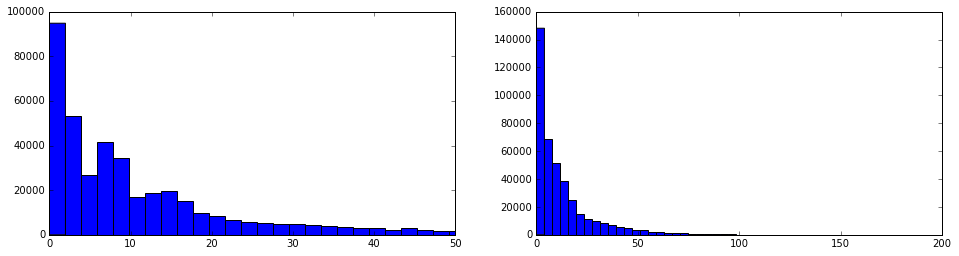

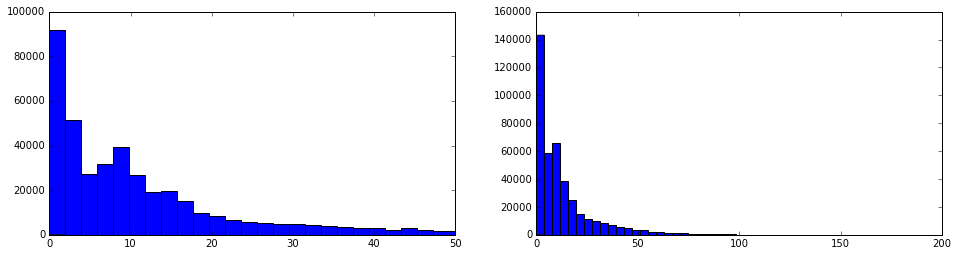

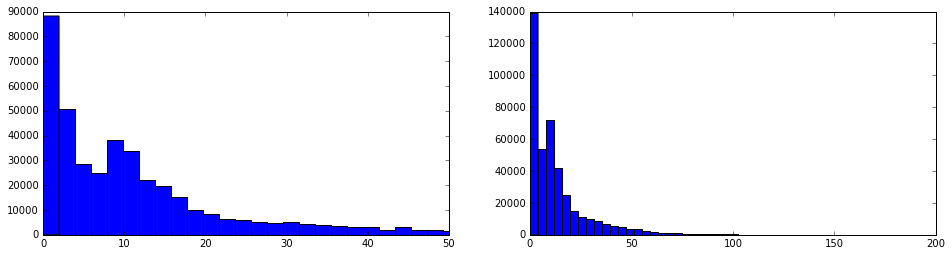

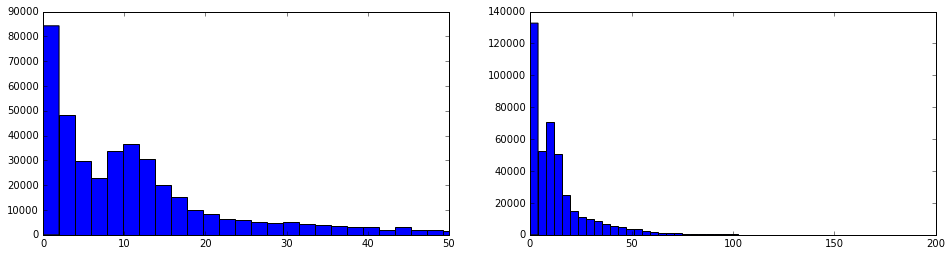

In [82]:
for thresh in [14, 15, 16, 17]:
    plot_hist(imp[thresh].predictdf.waittime)

In [73]:
imp

{14: None, 15: None, 16: None, 17: None}

In [83]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
pr = {}
imp = {}
cpu = 0 
for thresh in range(10, 14):
#     pr[thresh] = rc[cpu].apply_async(run_imputer, model, dfsource0, target_df, thresh, 48)
    imp[thresh] = run_imputer(model, dfsource0, target_df, thresh, 48)
    cpu += 1

34378
5160
1367
588
112
0
34378
5160
1367
588
112
0
34378
5160
1367
588
112
0
34378
5160
1367
588
112
0


## Threshold values of 10, 11, 12, 13

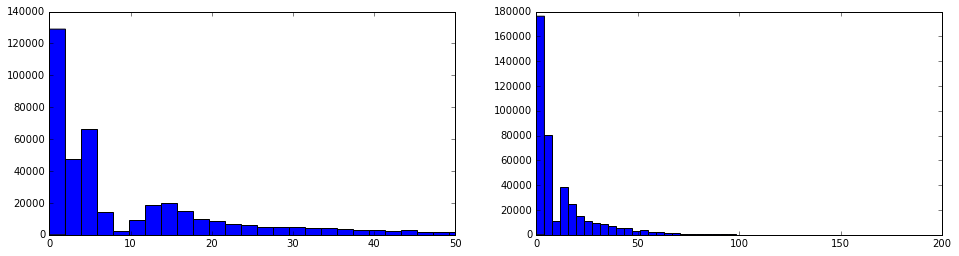

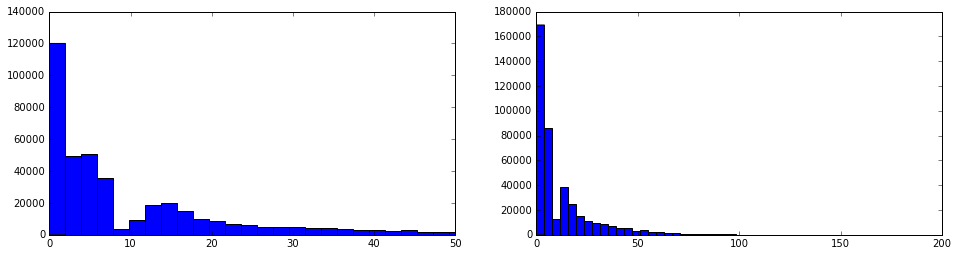

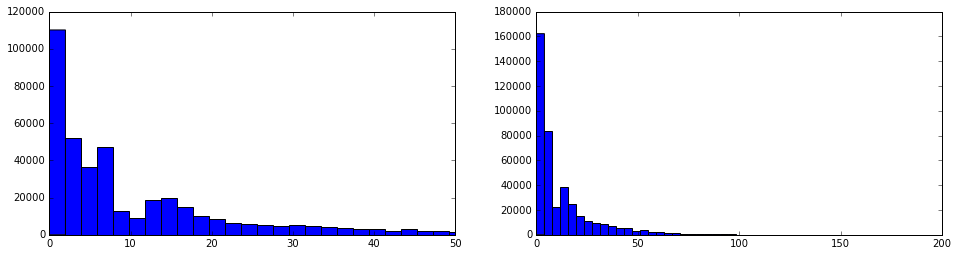

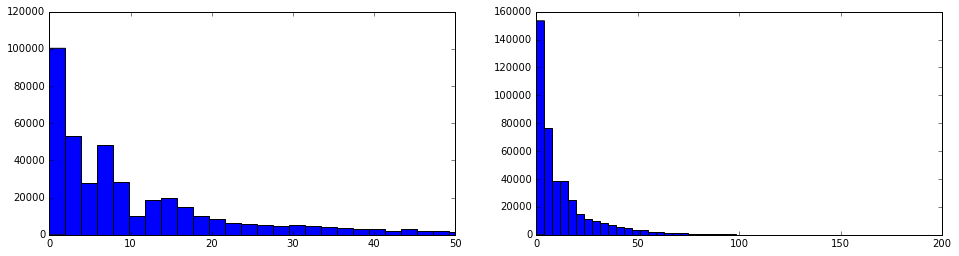

In [84]:
for thresh in range(10, 14):
    plot_hist(imp[thresh].predictdf.waittime)

## How is distribution affected by window size?  Threshold = 14

In [86]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
pr = {}
imp = {}
cpu = 0 
for window in [24, 32, 60]:
#     pr[thresh] = rc[cpu].apply_async(run_imputer, model, dfsource0, target_df, thresh, 48)
    imp[window] = run_imputer(model, dfsource0, target_df, 14, window)
    cpu += 1

92794
34378
12779
5160
2349
1367
930
588
284
112
35
0
68188
17585
5160
1936
1058
588
217
51
0
20653
2349
756
112
0


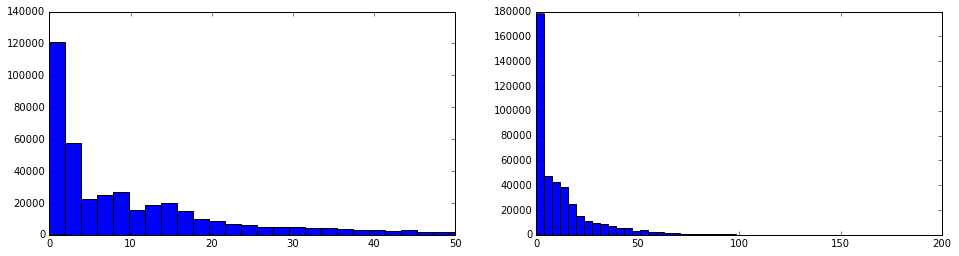

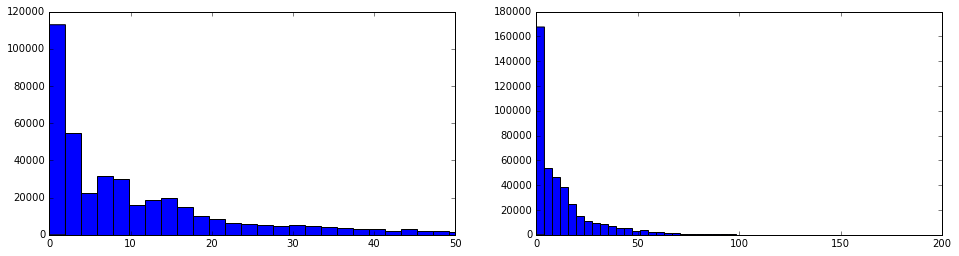

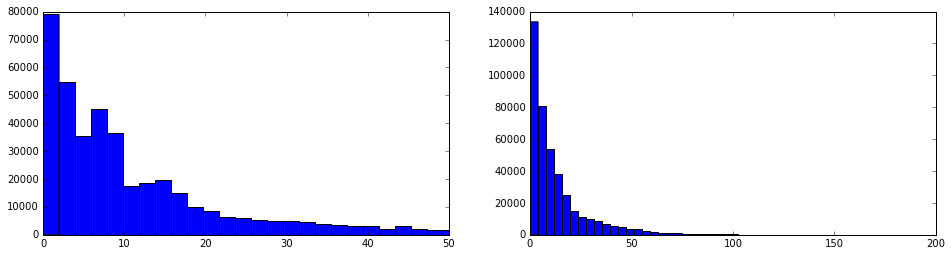

In [88]:
for window in [24, 32, 60]:
    plot_hist(imp[window].predictdf.waittime)

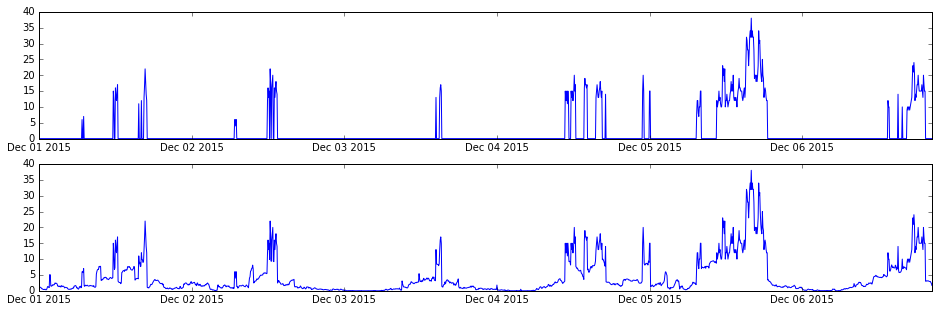

In [92]:
plot_line(imp[32].predictdf.waittime, '2015-12-1', '2015-12-7')

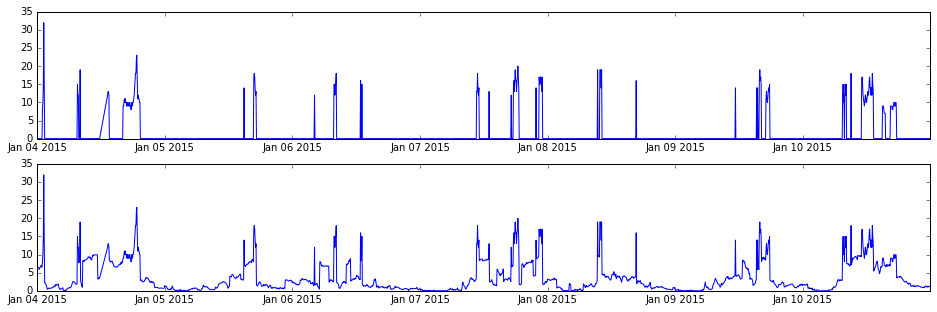

In [91]:
plot_line(imp[32].predictdf.waittime, '2015-1-4', '2015-1-11')

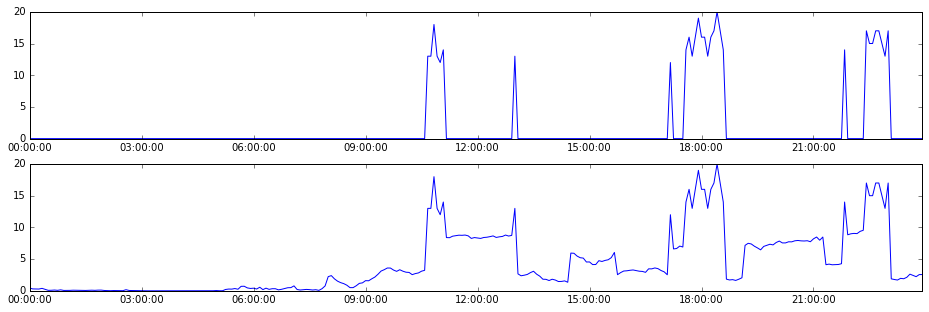

In [93]:
plot_line(imp[32].predictdf.waittime, '2015-1-7', '2015-1-8')

### Window = 32 & Threshold = 14
## Now try smoothing

In [95]:
import os
from ipyparallel import Client
rc = Client()
dview = rc[:]

# set proper working directory on all clients
cwd = os.getcwd()
dview.map(os.chdir, [cwd] * 32)
# print(dview.apply_sync(os.getcwd))

with dview.sync_imports():
    from BorderModel import smooth

importing smooth from BorderModel on engine(s)


In [101]:
pr2 = rc[0].apply_async(smooth, 4, 2, 'waittime', path='/home/ubuntu/BorderCrossing/data', df=imp[32].predictdf)

In [105]:
pr2.ready()

True

# Pacific Crossing 

In [3]:
target_query = '''
               select 
                   c.date,
                   month,
                   week,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 3
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=6
                   and valid = 1
                   and waittime is not null
                order by c.date;
               '''

target_df6 = pd_query(target_query)
target_df6 = target_df6.set_index('date')

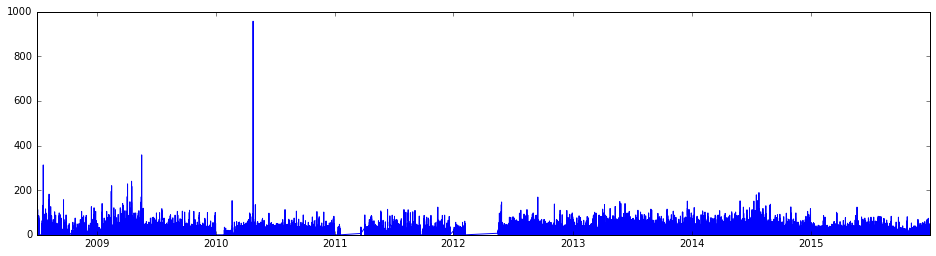

In [5]:
plt.figure(figsize=(16,4))
plt.plot(target_df6.waittime);

In [6]:
target_df6[target_df6.index > '2012-3-1'].head()

,month,week,dayofweek,minofday,volume,waittime
date,,,,,,
2012-05-17 12:10:00,5,20,3,730,6.24166,7
2012-05-17 12:15:00,5,20,3,735,7.78390,6
2012-05-17 12:20:00,5,20,3,740,9.23843,5
2012-05-17 12:25:00,5,20,3,745,10.41600,11
2012-05-17 12:30:00,5,20,3,750,11.12550,10


### Focus on data after 6/2012

In [10]:
start = '2012-6-1'
tdf6 = target_df6[target_df6.index > start]
dfsource = pd_query(source_query.format(start)).set_index('date')

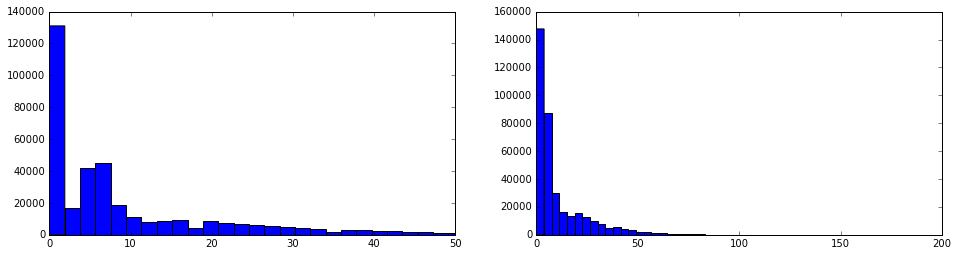

In [16]:
plot_hist(tdf6.waittime)

In [17]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
imp6 = {}
cpu = 0 
for thresh in range(3,8):
#     pr[thresh] = rc[cpu].apply_async(run_imputer, model, dfsource0, target_df, thresh, 48)
    imp6[thresh] = run_imputer(model, dfsource, tdf6, thresh, 48)
    cpu += 1

9
0
9
0
9
0
9
0
9
0


## Threshold = 5 gives a reasonable histogram
* high number of zeros
* no discontinuities above zero

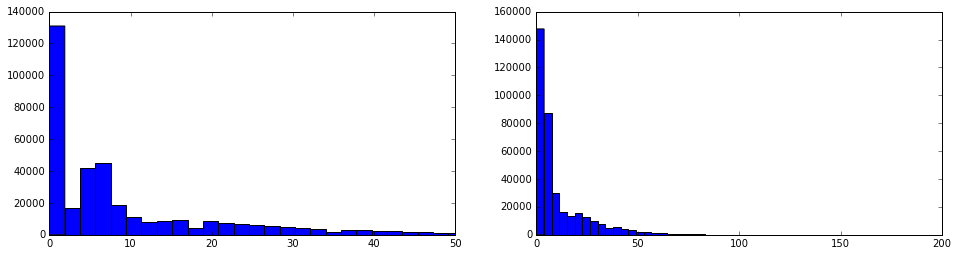

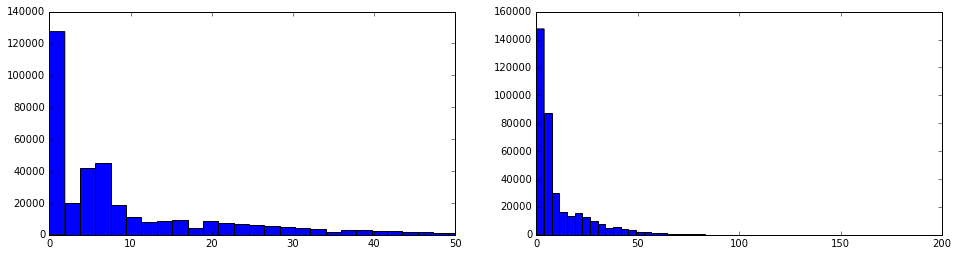

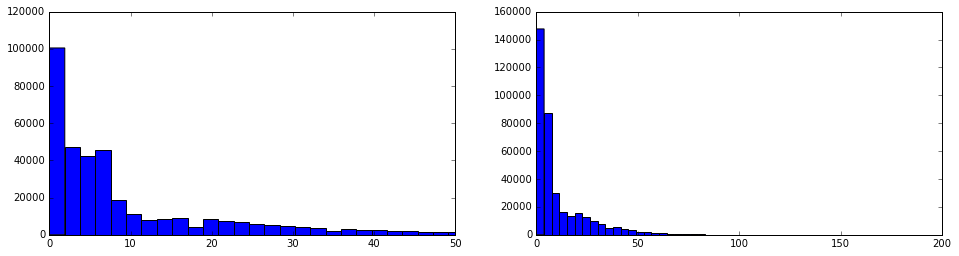

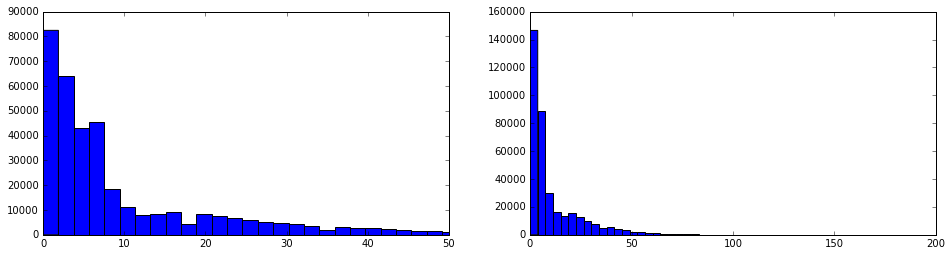

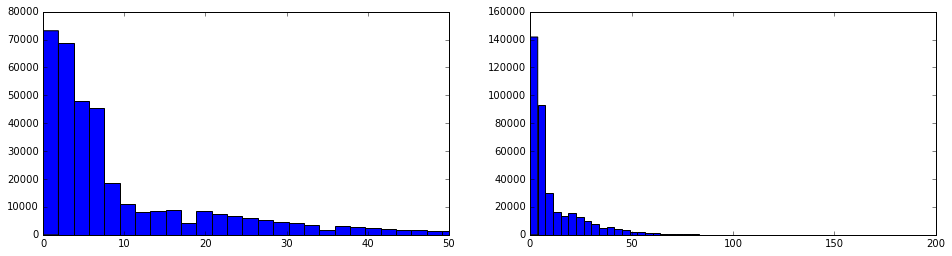

In [18]:
for thresh in range(3,8):
    plot_hist(imp6[thresh].predictdf.waittime)

## Test window size 

In [41]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
pr = {}
imp = {}
cpu = 0 
for window in [24, 32, 60]:
#     pr[thresh] = rc[cpu].apply_async(run_imputer, model, dfsource0, target_df, thresh, 48)
    imp[window] = run_imputer(model, dfsource, tdf6, 5, window)
    cpu += 1

5296
9
0
833
0
0


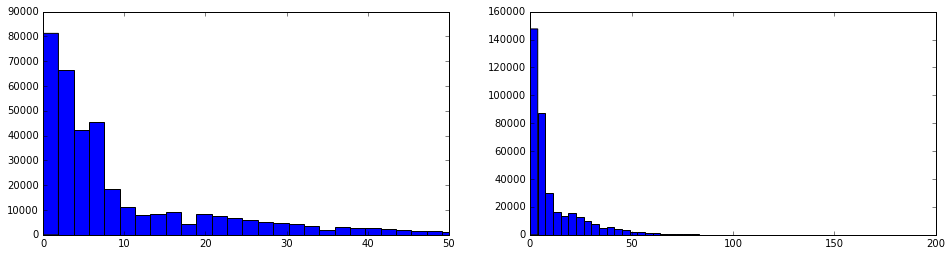

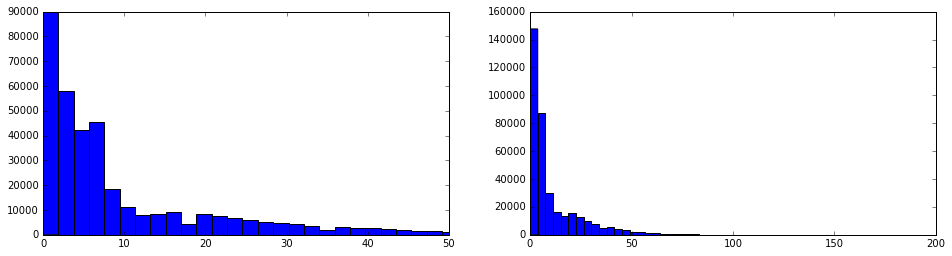

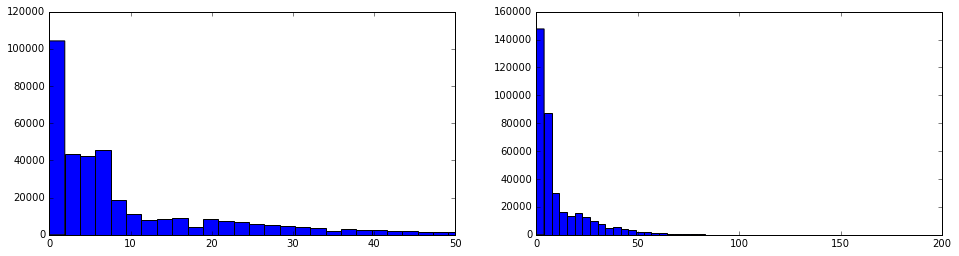

In [42]:
for window in [24, 32, 60]:
    plot_hist(imp[window].predictdf.waittime)

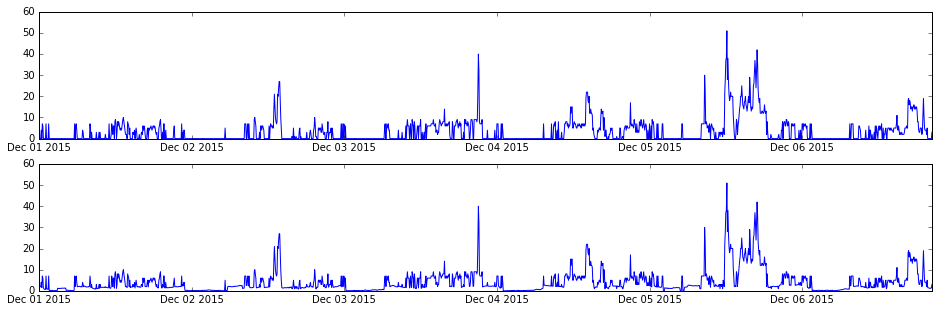

In [45]:
plot_line(target_df6, imp[32].predictdf.waittime, '2015-12-1', '2015-12-7')

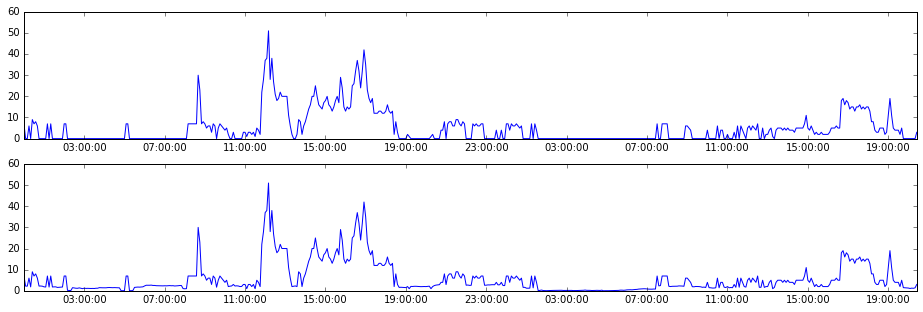

In [46]:
plot_line(target_df6, imp[32].predictdf.waittime, '2015-12-5', '2015-12-7')

## Window = 32 & Threshold = 5

In [49]:
import os
from ipyparallel import Client
rc = Client()
dview = rc[:]

# set proper working directory on all clients
cwd = os.getcwd()
dview.map(os.chdir, [cwd] * 32)
# print(dview.apply_sync(os.getcwd))

with dview.sync_imports():
    from BorderModel import smooth
    
pr6 = rc[0].apply_async(smooth, 4, 6, 'waittime', path='/home/ubuntu/BorderCrossing/data', df=imp[32].predictdf)

importing smooth from BorderModel on engine(s)


In [51]:
pr6.ready()

True

# Compare smoothed data

In [ ]:
smooth2 = select_mungedata_simple(4, 2, '2012-1-1', '2016-1-1')
smooth6 = select_mungedata_simple(4, 6, '2012-6-1', '2016-1-1')

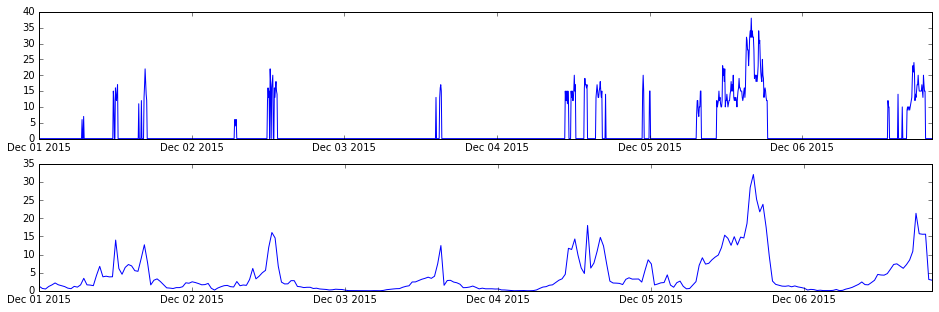

In [60]:
plot_line(target_df, smooth2.waittime, '2015-12-1', '2015-12-7')

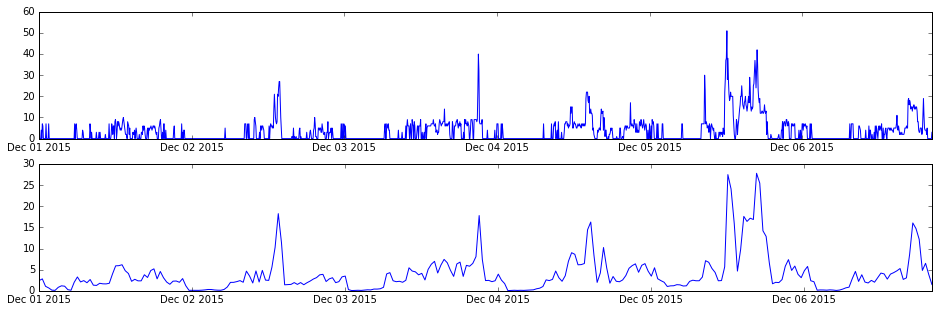

In [56]:
plot_line(target_df6, smooth6.waittime, '2015-12-1', '2015-12-7')

## Is there an opportunity to use data before 2012?  Perhaps previous cutoff was too aggressive.

## Peace Arch

In [32]:
start = '2011-1-1'
source_df = pd_query(source_query.format(start))
target_df = pd_query(target_query.format(3, 2, start))
target_df = target_df.set_index('date')
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
sdf = source_df
imp2 = run_imputer(model, source_df, target_df, 14, 32)

77789
19412
5633
1982
1058
588
217
51
0


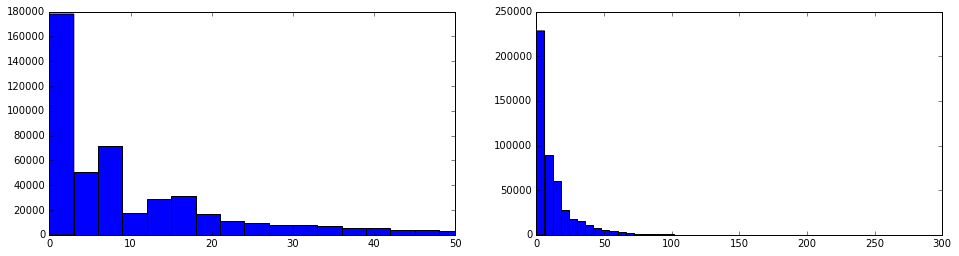

In [33]:
plot_hist(imp2.predictdf.waittime)

In [37]:
start = '2011-1-1'
source_df = pd_query(source_query.format(start))
target_df = pd_query(target_query.format(3, 2, start))
target_df = target_df.set_index('date')
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
sdf = source_df
imp2 = run_imputer(model, source_df, target_df, 15, 32)

77789
19412
5633
1982
1058
588
217
51
0


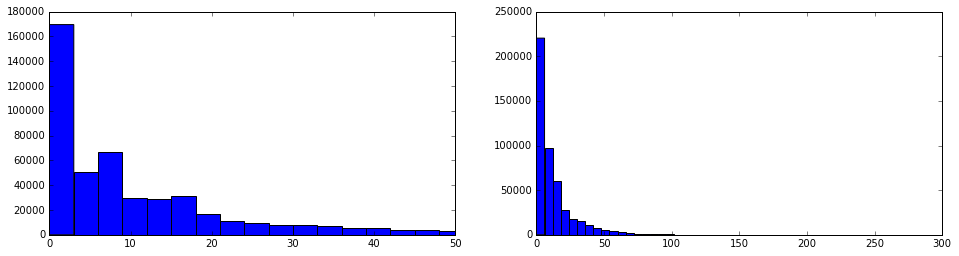

In [38]:
plot_hist(imp2.predictdf.waittime)

In [45]:
start = '2011-1-1'
source_df = pd_query(source_query.format(start))
target_df = pd_query(target_query.format(3, 2, start))
target_df = target_df.set_index('date')
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
sdf = source_df
imp2 = run_imputer(model, source_df, target_df, 16, 32)

77789
19412
5633
1982
1058
588
217
51
0


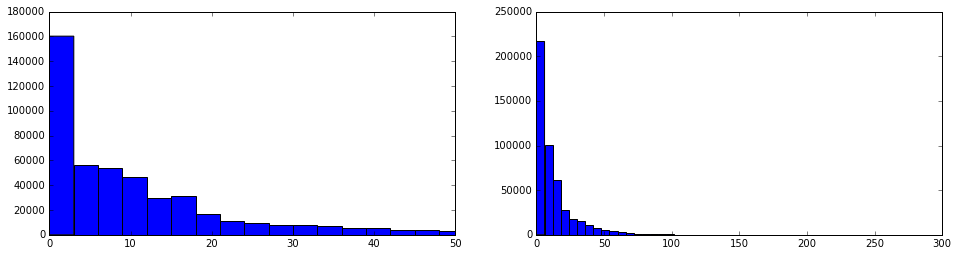

In [46]:
plot_hist(imp2.predictdf.waittime)

## Pacific Highway

In [41]:
start = '2011-1-1'
source_df = pd_query(source_query.format(start))
target_df = pd_query(target_query.format(3, 6, start))
target_df = target_df.set_index('date')
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
sdf = source_df
imp6 = run_imputer(model, source_df, target_df, 6, 32)

5084
121
0


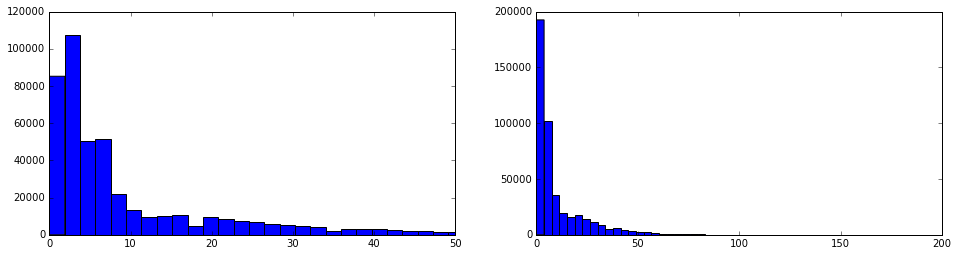

In [42]:
plot_hist(imp6.predictdf.waittime)

In [43]:
start = '2011-1-1'
source_df = pd_query(source_query.format(start))
target_df = pd_query(target_query.format(3, 6, start))
target_df = target_df.set_index('date')
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=96, bootstrap=True, oob_score=True)
sdf = source_df
imp6 = run_imputer(model, source_df, target_df, 5, 32)

5084
121
0


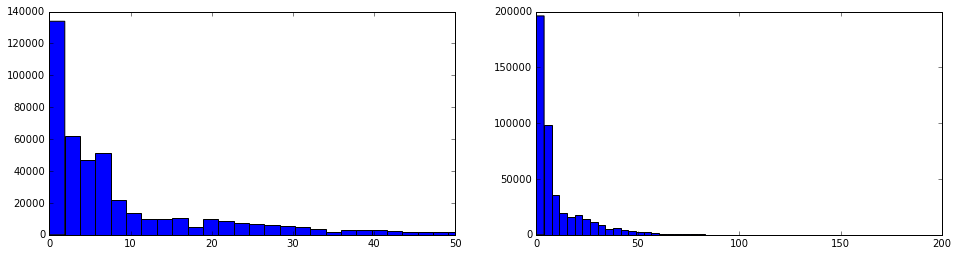

In [44]:
plot_hist(imp6.predictdf.waittime)

## Update impute parameters - 2011+
### Peace Arch - threshold=16
### Pacific Highway - threshold=5
## Recalculate smoothed data

In [47]:
import os
from ipyparallel import Client
rc = Client()
dview = rc[:]

# set proper working directory on all clients
cwd = os.getcwd()
dview.map(os.chdir, [cwd] * 32)
# print(dview.apply_sync(os.getcwd))

with dview.sync_imports():
    from BorderModel import smooth

pr2 = rc[0].apply_async(smooth, 4, 2, 'waittime', path='/home/ubuntu/BorderCrossing/data', df=imp2.predictdf)
pr6 = rc[0].apply_async(smooth, 4, 6, 'waittime', path='/home/ubuntu/BorderCrossing/data', df=imp6.predictdf)

importing smooth from BorderModel on engine(s)


In [48]:
smooth2 = select_mungedata_simple(4, 2, '2011-1-1', '2016-1-1')
smooth6 = select_mungedata_simple(4, 6, '2011-1-1', '2016-1-1')

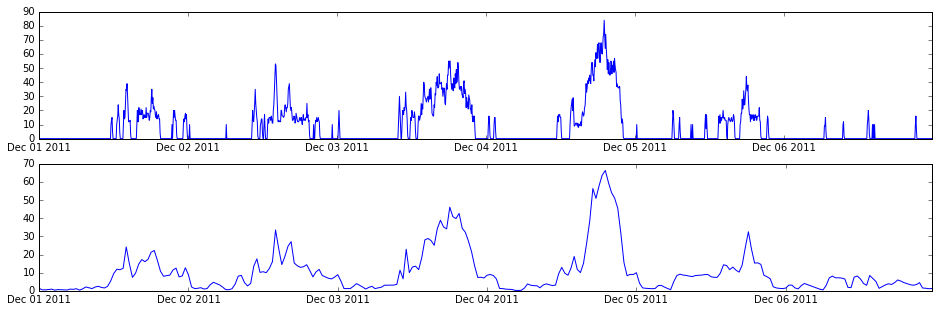

In [50]:
plot_line(target_df, smooth2.waittime, '2011-12-1', '2011-12-7')

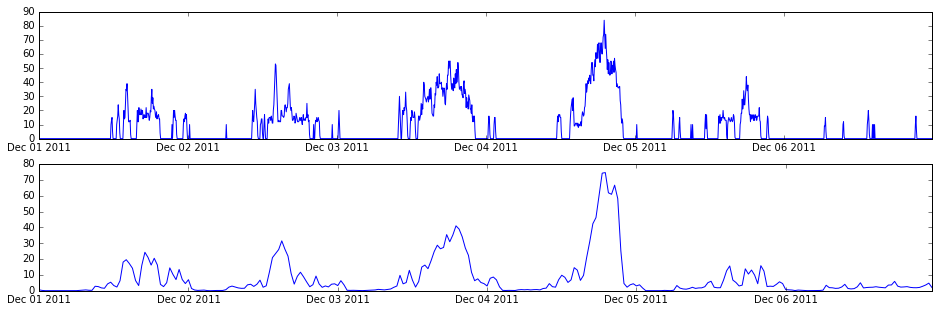

In [51]:
plot_line(target_df, smooth6.waittime, '2011-12-1', '2011-12-7')